# Project A: Northeastern SMILE Lab - Recognizing Faces in the Wild

# Importing Libraries

In [1]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import datasets, models, transforms
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, ImageFile
from tqdm import tqdm
import zipfile
import pandas as pd
import itertools
import random
import torch.nn.functional as F
# Instructs PIL to ignore the file's completeness and attempt to open it anyway
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Data Preparation

In [2]:
# Dataset from Kaggle

print("Extracting Train data")
with zipfile.ZipFile('/kaggle/input/recognizing-faces-in-the-wild/train.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/data/train/')
print("Extracting Test data")
with zipfile.ZipFile('/kaggle/input/recognizing-faces-in-the-wild/test.zip', 'r') as zip_ref:
    zip_ref.extractall('/kaggle/working/data/test/')
    
root_path = '/kaggle/working/data/'

Extracting Train data
Extracting Test data


In [3]:
# Extract all combinations of people in train dataset
people = set()
for dirname, _, filenames in os.walk(root_path+'/train/'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        path = os.path.join(dirname, filename)
        path = path.replace("/kaggle/working/data//train/","")
        parts = path.split('/') 
        people.add((parts[0],parts[1])) # (FamilyID, PersonID)

all_pairs = set(itertools.combinations(people, 2)) # all combs of people. these paths all exist but may not be openable
'''
sample of all_pairs:
{(('F0665', 'MID5'), ('F0601', 'MID24')),
 (('F0735', 'MID2'), ('F0017', 'MID3')),
 (('F0086', 'MID4'), ('F0126', 'MID6')),
 (('F0909', 'MID2'), ('F0601', 'MID2')),
 (('F0826', 'MID1'), ('F0197', 'MID3')),
 (('F0947', 'MID3'), ('F0101', 'MID1')),
 (('F0216', 'MID5'), ('F0393', 'MID5')),
'''


"\nsample of all_pairs:\n{(('F0665', 'MID5'), ('F0601', 'MID24')),\n (('F0735', 'MID2'), ('F0017', 'MID3')),\n (('F0086', 'MID4'), ('F0126', 'MID6')),\n (('F0909', 'MID2'), ('F0601', 'MID2')),\n (('F0826', 'MID1'), ('F0197', 'MID3')),\n (('F0947', 'MID3'), ('F0101', 'MID1')),\n (('F0216', 'MID5'), ('F0393', 'MID5')),\n"

In [4]:
related_df = pd.read_csv("/kaggle/input/recognizing-faces-in-the-wild/train_relationships.csv")

In [5]:
df = related_df.copy()
new = df["p1"].str.split("/", n = 1, expand = True)

# making separate first name column from new data frame 
df["Family1"]= new[0]
# making separate last name column from new data frame 
df["Person1"]= new[1]

# Dropping old Name columns
df.drop(columns =["p1"], inplace = True)

new = df["p2"].str.split("/", n = 1, expand = True)

# making separate first name column from new data frame 
df["Family2"]= new[0]
# making separate last name column from new data frame 
df["Person2"]= new[1]

# Dropping old Name columns
df.drop(columns =["p2"], inplace = True)
df.head()

,Family1,Person1,Family2,Person2
0,F0002,MID1,F0002,MID3
1,F0002,MID2,F0002,MID3
2,F0005,MID1,F0005,MID2
3,F0005,MID3,F0005,MID2
4,F0009,MID1,F0009,MID4


In [6]:
# A set of all possible related people - p1 to p2 and p2 to p1
related_pairs_set = set()
for index, row in df.iterrows():
    related_pairs_set.add(((row['Family1'], row['Person1']), (row['Family2'], row['Person2'])))
    related_pairs_set.add(((row['Family2'], row['Person2']), (row['Family1'], row['Person1'])))

In [7]:
unrelated_pairs = all_pairs - related_pairs_set

In [8]:
# Create a DataFrame for unrelated pairs
unrelated_data = []
for pair1,pair2 in unrelated_pairs:
    family1, person1 = pair1
    family2, person2 = pair2
    unrelated_data.append([family1, person1, family2, person2, 0])
unrelated_df = pd.DataFrame(unrelated_data[:3364], columns=['Family1', 'Person1', 'Family2', 'Person2', 'related'])
unrelated_df.head()

,Family1,Person1,Family2,Person2,related
0,F0540,MID1,F0431,MID4,0
1,F0303,MID4,F0805,MID2,0
2,F0805,MID5,F0128,MID4,0
3,F0339,MID5,F0227,MID2,0
4,F0664,MID8,F0593,MID4,0


In [9]:
unrelated_df.shape # Selected 3600-236 unrealated pairs to have a balanced dataset

(3364, 5)

In [10]:
# Add a 'related' column to the related pairs DataFrame
df['related'] = 1
df.head()

,Family1,Person1,Family2,Person2,related
0,F0002,MID1,F0002,MID3,1
1,F0002,MID2,F0002,MID3,1
2,F0005,MID1,F0005,MID2,1
3,F0005,MID3,F0005,MID2,1
4,F0009,MID1,F0009,MID4,1


In [11]:
# Combine the related and unrelated pairs into a single DataFrame
combined_df = pd.concat([df, unrelated_df], ignore_index=True)
combined_df

,Family1,Person1,Family2,Person2,related
0,F0002,MID1,F0002,MID3,1
1,F0002,MID2,F0002,MID3,1
2,F0005,MID1,F0005,MID2,1
3,F0005,MID3,F0005,MID2,1
4,F0009,MID1,F0009,MID4,1
...,...,...,...,...,...
6957,F0160,MID6,F0257,MID1,0
6958,F0833,MID6,F0298,MID6,0
6959,F0984,MID7,F0955,MID5,0
6960,F0168,MID3,F0838,MID2,0


In [12]:
# Shuffle the combined DataFrame to mix related and unrelated pairs
combined_df = combined_df.sample(frac=1).reset_index(drop=True)
combined_df

,Family1,Person1,Family2,Person2,related
0,F0735,MID2,F0735,MID3,1
1,F0481,MID1,F0481,MID3,1
2,F0070,MID6,F0070,MID1,1
3,F0842,MID1,F0695,MID3,0
4,F0202,MID2,F0202,MID5,1
...,...,...,...,...,...
6957,F0881,MID5,F0881,MID2,1
6958,F0820,MID1,F0203,MID1,0
6959,F0977,MID1,F0977,MID7,1
6960,F0113,MID3,F0113,MID4,1


In [13]:

def check_images_exist(df, base_path):
    # This list will hold the indices of the rows with missing images or folders
    missing_images_or_folders_indices = []
    
    # Iterate over the DataFrame rows
    for index, row in df.iterrows():
        # Construct the folder path for Family1/Person1
        person1_path = os.path.join(base_path, 'train', row['Family1'], row['Person1'])
        # Construct the folder path for Family2/Person2
        person2_path = os.path.join(base_path, 'train', row['Family2'], row['Person2'])
        
        # Initialize a flag to indicate if the image or folder is missing
        missing_image_or_folder = False
        
        # Check if the person1_path directory exists and has at least one image
        if os.path.isdir(person1_path):
            person1_images = [f for f in os.listdir(person1_path) if f.endswith('.jpg')]
            if not person1_images:
                missing_image_or_folder = True
        else:
            missing_image_or_folder = True
            
        # Check if the person2_path directory exists and has at least one image
        if os.path.isdir(person2_path):
            person2_images = [f for f in os.listdir(person2_path) if f.endswith('.jpg')]
            if not person2_images:
                missing_image_or_folder = True
        else:
            missing_image_or_folder = True
        
        # If either directory is missing or empty, add the index to the list
        if missing_image_or_folder:
            missing_images_or_folders_indices.append(index)
            
    # Return the indices of rows with missing images
    return missing_images_or_folders_indices

# Define the base path where the images are stored
base_path = '/kaggle/working/data'

# Call the function and get the indices of rows with missing images
indices_with_missing_images = check_images_exist(combined_df, base_path)

# If you want to remove rows with missing images from the DataFrame
# combined_df.drop(indices_with_missing_images, inplace=True)

# If you want to inspect the rows with missing images
# print(combined_df.loc[indices_with_missing_images])

In [14]:
print("There are {} rows with missing images or folders. They will be deleted.".format(len(indices_with_missing_images)))

There are 236 rows with missing images or folders. They will be deleted.


In [15]:
num_related_del = combined_df.loc[indices_with_missing_images]['related'].sum()
print("There are {0} related and {1} unrelated pairs out of {2} which will be deleted".format(num_related_del, len(indices_with_missing_images)-num_related_del, len(indices_with_missing_images)))

There are 236 related and 0 unrelated pairs out of 236 which will be deleted


In [16]:
# Remove rows with missing images from the DataFrame
combined_df.drop(indices_with_missing_images, inplace=True)

In [17]:
print(combined_df['related'].value_counts())# make sure df is balanced - some items will be deleted from the related pairs later

related
0    3364
1    3362
Name: count, dtype: int64


In [18]:
combined_df.to_csv(root_path+'/combined_pairs.csv', index=False)

In [19]:
combined_df.head()

,Family1,Person1,Family2,Person2,related
0,F0735,MID2,F0735,MID3,1
1,F0481,MID1,F0481,MID3,1
3,F0842,MID1,F0695,MID3,0
4,F0202,MID2,F0202,MID5,1
5,F0332,MID3,F0716,MID5,0


# Custom Dataset class

In [20]:
class CustomFamilyDataset(Dataset):
    ''' Custom Dataset for relationship data'''
    def __init__(self, rel_df, root_path, transforms = None):
        '''
        args:
        rel_df (df) : combined_df of relationship data prepared in previous steps
        root_path (string) : to find the location of images based on the rel_df
        transforms (callable, optional) : transforms to be applied on per image
        '''
        self.rel_df = rel_df
        self.root_path = root_path
        self.transforms = transforms
        
    def __len__(self):
        return self.rel_df.shape[0]
    
    def __getitem__(self,idx):
        # get the idx-th row from self.rel_df
        # Use it to build the path to the imgs of the 2 persons.
        # Each path can contain multiple images. The number of images could be different per person.
        
        person1_path = os.path.join(self.root_path,'train',self.rel_df.iloc[idx]['Family1'],self.rel_df.iloc[idx]['Person1'])
        person2_path = os.path.join(self.root_path,'train',self.rel_df.iloc[idx]['Family2'],self.rel_df.iloc[idx]['Person2'])
        
        # Iterate thru each image/person, open them using Image and append to a list
        imgs1 = []
        imgs2 = []
        person1_images = [f for f in os.listdir(person1_path) if f.endswith('.jpg')]
        img_path = random.choice(person1_images) # chose one at random
        img_path = os.path.join(person1_path,img_path)
        img1 = Image.open(img_path)  # Use PIL to open the image
        
        person2_images = [f for f in os.listdir(person2_path) if f.endswith('.jpg')]
        img_path = random.choice(person2_images) # chose one at random
        img_path = os.path.join(person2_path,img_path)
        img2 = Image.open(img_path)  # Use PIL to open the image
        
        if self.transforms is not None:
            img1 = self.transforms(img1)
            img2 = self.transforms(img2)
        
        # LABEL for this pair
        label = self.rel_df.iloc[idx]['related']
        
        return img1,img2,label
        
        

# Randomly view dataset

In [21]:
faces = CustomFamilyDataset(combined_df,root_path)

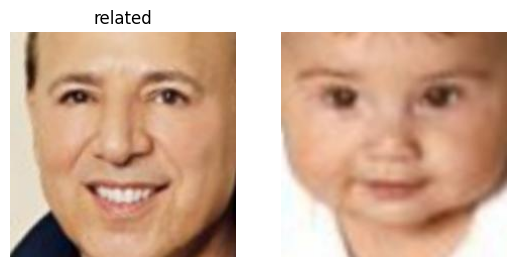

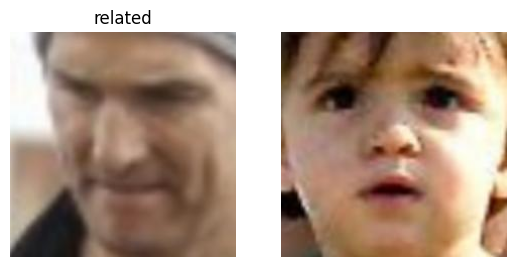

In [22]:
for i, (img1,img2,label) in enumerate(faces):

    title = 'related' if label==1 else 'unrelated'
    
    ax = plt.subplot(1, 2, 1)
    plt.title(title)
    plt.imshow(img1)
    plt.axis('off')
    ax = plt.subplot(1, 2, 2)
    plt.imshow(img2)
       
    plt.axis('off')
    if i==1:
        break
    
    plt.show()


# SiameseNN

In [23]:
#import Facenet libraries
!pip install /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-2.2.9-py3-none-any.whl --force-reinstall

Processing /kaggle/input/facenet-pytorch-vggface2/facenet_pytorch-2.2.9-py3-none-any.whl
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 74.8 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.8/144.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.4/70.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.4
    Uninstalling numpy-1.26.4:
      Successfully uninstalled numpy-1.26.4
  Attempting uninstall: idna
   

In [24]:
from facenet_pytorch import InceptionResnetV1

In [25]:
# The base network is Inceptionnetv1 pretrained on the vggface2 dataset. Weights of all layers of the
# basenetwork are frozen.
# output of is a FC layer with 512 out features
class BaseNetwork(nn.Module):
    def __init__(self, pretrained=True):
        super().__init__()
        self.base_model = InceptionResnetV1(pretrained='vggface2')#.eval()
        #self.base_model = torchvision.models.resnet18(pretrained=False)
        #self.base_model.load_state_dict(torch.load("/kaggle/input/vggface2/pytorch/default/1/20180402-114759-vggface2.pt"))
        # Last layer is :
        # 
        if pretrained == True:
            for child in list(self.base_model.children()):
                for param in child.parameters():
                    param.requires_grad = False # Set requires_grad to False to freeze parameters
        
    def forward(self, x):
        # Pass input through the base model
        out = self.base_model(x)
        return out

In [26]:
# Some math is done on the outputs of the 2 base networks as per previous competition submissions with my own modifications.
# I also included 1 neuron each activated by pairwise distance and cosin similarity of the image features.
# This significantly improved accuracy.
# All this math+dist+similarity is fed to a FC network.
# Finally a sigmoid activation is done.
class SiameseNetwork(nn.Module):
    def __init__(self, base_model):
        super(SiameseNetwork, self).__init__()
        self.base_model = base_model
        
        self.cos = nn.CosineSimilarity(dim=1, eps=1e-6)
        self.dist = nn.PairwiseDistance(p=2)
        self.fc1 = nn.Linear(in_features=2050, out_features=1024) 
        self.dropout1 = nn.Dropout(p=0.6)
        self.fc2 = nn.Linear(in_features=1024, out_features=512) 
        self.dropout2 = nn.Dropout(p=0.6)
        self.fc3 = nn.Linear(in_features=512, out_features=256)
        self.dropout3 = nn.Dropout(p=0.6)
        self.fc4 = nn.Linear(in_features=256, out_features=1)
        
    def forward(self, img1, img2):
        x1 = self.base_model(img1)# batch_size, 512 
        x2 = self.base_model(img2)# batch_size, 512 

        x3 = x1 - x2
        x4 = x3 * x3 # (x1-x2)^2
        x5 = x4 * x3 # (x1-x2)^3
        
        x1_ = x1 * x1
        x2_ = x2 * x2
        x6 = x1_ - x2_ # (x1^2 - x2^2)
        
        
        x7 = torch.cat((x4, x3), dim=1)# (batch_size, 1024)
        x8 = torch.cat((x7, x5), dim=1)# (batch_size, 1536)
        x9 = torch.cat((x8, x6), dim=1)# (batch_size, 2048)
        
        x6 = self.cos(x1,x2).unsqueeze(1) # (batch_size, 1)
        x10 = self.dist(x1,x2).unsqueeze(1) # (batch_size, 1)
        
        x11 = torch.cat((x9, x6), dim=1)# (batch_size, 2049)
        x = torch.cat((x10, x11), dim=1)# (batch_size, 2050)
        
        x = self.dropout1(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = F.relu(self.fc2(x))
        x = self.dropout3(x)
        x = F.relu(self.fc3(x))
        out = torch.sigmoid(self.fc4(x))

        return out

# Utility functions

### Save checkpoint

In [27]:
def save_checkpoint(epoch, net, optimizer, history):
    state = {'epoch':epoch,
            'net':net,
            'optimizer':optimizer,
            'history' : history}
    filename = 'checkpoint' + str(epoch) + ".pth"
    torch.save(state, filename)

### Train and Validate function

In [28]:
def train_and_validate(train_loader, val_loader, siamese_net, criterion, criterion_CL, optimizer, epoch, history):
    
    #
    train_counter = []
    train_loss_history = []
    train_iteration_number= 0

    val_counter = []
    val_loss_history = []
    val_iteration_number= 0
    
    
    total_loss, total_correct, total_images = 0, 0, 0
    #
    siamese_net.train()
    
    counter = []
    loss_history = [] 
    iteration_number= 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    data_bar = tqdm(train_loader, desc="Train", position=0, leave=True) # Progress bar for training
    # Iterate over batches
    for img1, img2, labels in data_bar:
        
        img1, img2, labels = img1.to(device), img2.to(device), labels.float().to(device)

        # Zero the gradients
        optimizer.optimizer.zero_grad()
        
        # Pass in the two images into the network and obtain the prob
        out = siamese_net(img1, img2) # out size is (batch_size,1)
        
        out = out.squeeze().float()
        
        #print(type(out))
        #print(out.shape)
        # Pass the outputs of the networks and label into the loss function
        loss1 = criterion(out, labels)
        loss2 = criterion_CL(img1, img2, labels) # Contrastive loss
        
        loss = loss1 + loss2 # Add BCE loss with CL

        # Calculate the backpropagation
        loss.backward()

        # Optimize
        optimizer.step()
        ################################################################################################
        
        # Calculate total loss and accuracy for the epoch
        total_loss += loss.item() * img1.size(0)
        predicted = (out > 0.5).float()
        
        total_correct += (predicted == labels).sum().item()
        total_images += labels.size(0)

        # Update progress bar with current loss and accuracy
        data_bar.set_postfix(loss=(total_loss/total_images), accuracy=total_correct/total_images)
                

            
    history['train_loss'].append(total_loss / total_images)
    history['train_accuracy'].append(total_correct / total_images)
    training_loss = total_loss / total_images
        
    # VALIDATION LOOP
    total_loss, total_correct, total_images = 0, 0, 0
    siamese_net.eval()
    with torch.no_grad():
        data_bar = tqdm(val_loader, desc="Val  ", position=0, leave=True)
        for i, (img1, img2, labels) in enumerate(data_bar):

            img1, img2, labels = img1.to(device), img2.to(device), labels.to(device).float()

            out = siamese_net(img1, img2).squeeze().float()

            loss1 = criterion(out, labels)
            loss2 = criterion_CL(img1, img2, labels) # Contrastive loss

            loss = loss1 + loss2
            
            # Calculate total validation loss and accuracy
            total_loss += loss.item() * img1.size(0)
            predicted = (out > 0.5).float()
            total_correct += (predicted == labels).sum().item()
            total_images += labels.size(0)
            data_bar.set_postfix(loss=(total_loss/total_images), accuracy=total_correct/total_images)
            
    # Store the average validation loss and accuracy for this epoch in the history
    history['val_loss'].append(total_loss / total_images)
    history['val_accuracy'].append(total_correct / total_images)
    
     # Print summary of the epoch
    print(f"Epoch {epoch+1}: Train Loss: {history['train_loss'][-1]:.4f}, Train Acc: {history['train_accuracy'][-1]:.4f}, Val Loss: {history['val_loss'][-1]:.4f}, Val Acc: {history['val_accuracy'][-1]:.4f}")
    
    
    return history

### Contrastive Loss

In [29]:
class ContrastiveLoss(torch.nn.Module):
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
      # Calculate the euclidean distance and calculate the contrastive loss
      euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)

      loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                    (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


      return loss_contrastive

### Adam with warmup

In [30]:
class AdamWarmup:
    
    def __init__(self, model_size, warmup_steps, optimizer):
        
        self.model_size = model_size
        self.warmup_steps = warmup_steps
        self.optimizer = optimizer
        self.current_step = 0
        self.lr = 0
        
    def get_lr(self):
        return self.model_size ** (-0.5) * min(self.current_step ** (-0.5), self.current_step * self.warmup_steps ** (-1.5))
    
    def step(self):
        self.current_step += 1
        lr = self.get_lr()
        for param_group in self.optimizer.param_groups:
            param_group['lr'] = lr
        self.lr = lr
        # update weights
        self.optimizer.step()

# Training cycle

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [32]:
checkpoint = None
#checkpoint = '/kaggle/working/checkpoint20.pth'
batch_size = 32
start_epoch = 0
epochs = 5
net = SiameseNetwork(BaseNetwork())
optimizer = optim.Adam(net.parameters(), lr = 0.001)
warmup_optimizer = AdamWarmup(model_size = 512, warmup_steps = 1000, optimizer = optimizer)

if checkpoint is None:
    print("Starting training from scratch")
    net = net.to(device)
    history = {'train_loss': [], 'train_accuracy': [], 'val_loss': [], 'val_accuracy': []}

else:
    checkpoint = torch.load(checkpoint)
    start_epoch = checkpoint['epoch'] + 1
    net.load_state_dict(checkpoint['net'])
    net = net.to(device)
    optimizer.load_state_dict(checkpoint['optimizer'])
    history = checkpoint['history']


criterion = torch.nn.BCELoss(size_average=True).to(device)
criterion_CL = ContrastiveLoss().to(device)

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
train_transforms = transforms.Compose([transforms.Resize(255),
                                        transforms.RandomRotation(60),  # Randomly rotate images in the range [-60 degrees, 60 degrees]
                                        transforms.RandomHorizontalFlip(),  # Randomly flip images horizontally (default probability=0.5)
                                        transforms.RandomVerticalFlip(),  # Randomly flip images vertically (default probability=0.5)
                                        transforms.ColorJitter(brightness=0.2, contrast=0.2),  # Randomly change brightness and contrast
                                       transforms.ToTensor(), normalize])
val_transforms = transforms.Compose([transforms.Resize(255),transforms.ToTensor(), normalize])

train_df,valid_df = np.split(combined_df, [int(.8*len(combined_df))])

train_dataset = CustomFamilyDataset(train_df,root_path, transforms = train_transforms)
val_dataset = CustomFamilyDataset(valid_df,root_path, transforms = val_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory = True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory = True, drop_last=True)

/opt/conda/lib/python3.10/site-packages/facenet_pytorch/models/inception_resnet_v1.py:336: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict.update(torch.load(cached_

Starting training from scratch


/opt/conda/lib/python3.10/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))
/opt/conda/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.


## Model summary

In [33]:
#!pip install torchinfo
from torchinfo import summary
summary(net, input_size=((1,3,255, 255),(1,3,255, 255)), row_settings = ("depth","var_names",))

Layer (type (var_name):depth-idx)                            Output Shape              Param #
SiameseNetwork (SiameseNetwork)                              [1, 1]                    --
├─BaseNetwork (base_model): 1-1                              [1, 512]                  --
│    └─InceptionResnetV1 (base_model): 2-1                   [1, 512]                  4,427,703
│    │    └─BasicConv2d (conv2d_1a): 3-1                     [1, 32, 127, 127]         (928)
│    │    └─BasicConv2d (conv2d_2a): 3-2                     [1, 32, 125, 125]         (9,280)
│    │    └─BasicConv2d (conv2d_2b): 3-3                     [1, 64, 125, 125]         (18,560)
│    │    └─MaxPool2d (maxpool_3a): 3-4                      [1, 64, 62, 62]           --
│    │    └─BasicConv2d (conv2d_3b): 3-5                     [1, 80, 62, 62]           (5,280)
│    │    └─BasicConv2d (conv2d_4a): 3-6                     [1, 192, 60, 60]          (138,624)
│    │    └─BasicConv2d (conv2d_4b): 3-7                     [

## Visualize train dataset

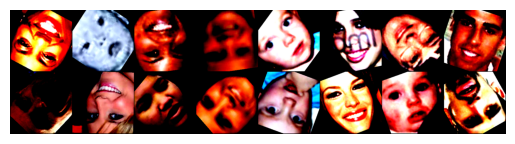

unrelated related unrelated related related related related related 


In [34]:
import torchvision
visualize_dataloader = DataLoader(train_dataset,
                        shuffle=True,
                        batch_size=8)
dataiter = iter(visualize_dataloader)

example_batch = next(dataiter)

concatenated = torch.cat((example_batch[0],example_batch[1]),0)
npimg = torchvision.utils.make_grid(concatenated).numpy()
plt.axis("off")
plt.imshow(np.transpose(npimg, (1, 2, 0)))
plt.show()
out = ''
for i in example_batch[2].numpy():
    out+= 'related ' if i==1 else 'unrelated '
print(out)


## Training and Validation Loop


In [35]:
# main training loop

t_counter = []
t_loss_history = []
v_counter = []
v_loss_history = []
for epoch in range(start_epoch, epochs):
    print(f"Starting epoch : {epoch}")
    history = train_and_validate(train_loader = train_loader,
                                  val_loader = val_loader,
                                  siamese_net = net,
                                  criterion = criterion,
                                  criterion_CL = criterion_CL,
                                  optimizer = warmup_optimizer,
                                  epoch = epoch,
                                history = history)
    for param_group in warmup_optimizer.optimizer.param_groups:
        print(f"Learning rate was : {param_group['lr']}")
    save_checkpoint(epoch, net.state_dict(), optimizer.state_dict(), history)
    
print("Done with training and validation")   

Starting epoch : 0


Val  : 100%|██████████| 42/42 [00:13<00:00,  3.18it/s, accuracy=0.546, loss=219]


Epoch 1: Train Loss: 253.5287, Train Acc: 0.5087, Val Loss: 218.6900, Val Acc: 0.5461
Learning rate was : 0.00023478713763747794
Starting epoch : 1


Val  : 100%|██████████| 42/42 [00:12<00:00,  3.26it/s, accuracy=0.61, loss=220] 


Epoch 2: Train Loss: 251.1176, Train Acc: 0.5517, Val Loss: 220.0158, Val Acc: 0.6101
Learning rate was : 0.0004695742752749559
Starting epoch : 2


Val  : 100%|██████████| 42/42 [00:13<00:00,  3.14it/s, accuracy=0.606, loss=216]


Epoch 3: Train Loss: 251.2644, Train Acc: 0.5766, Val Loss: 216.4487, Val Acc: 0.6057
Learning rate was : 0.0007043614129124339
Starting epoch : 3


Val  : 100%|██████████| 42/42 [00:13<00:00,  3.06it/s, accuracy=0.606, loss=219]


Epoch 4: Train Loss: 253.5102, Train Acc: 0.5761, Val Loss: 218.9812, Val Acc: 0.6057
Learning rate was : 0.0009391485505499118
Starting epoch : 4


Val  : 100%|██████████| 42/42 [00:13<00:00,  3.23it/s, accuracy=0.635, loss=220]


Epoch 5: Train Loss: 249.3006, Train Acc: 0.5882, Val Loss: 220.4669, Val Acc: 0.6347
Learning rate was : 0.0011739356881873898
Done with training and validation


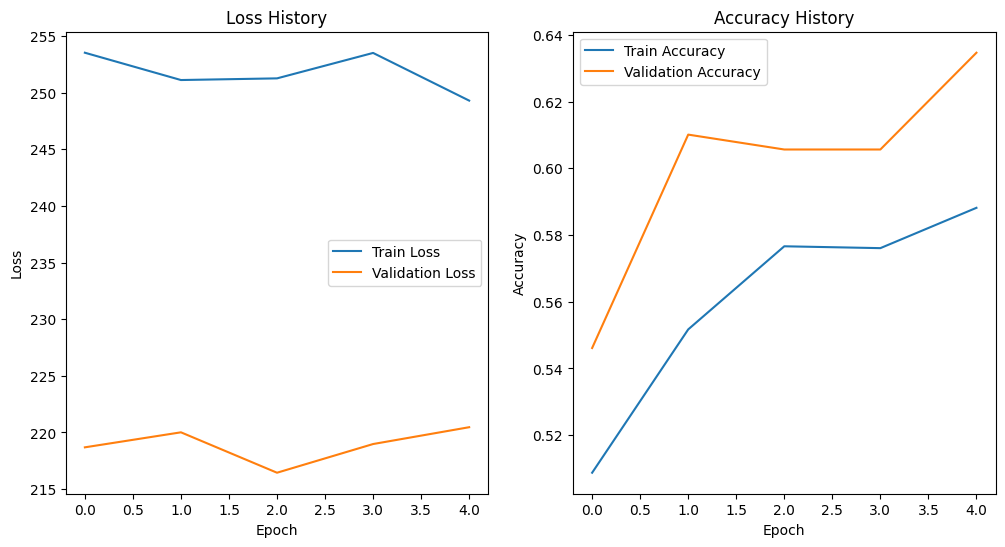

In [36]:
# Function to plot training history
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['train_accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy History')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()


plot_history(history)

# Testing the saved model

In [37]:
#checkpoint = torch.load('/kaggle/working/checkpoint34.pth')

/tmp/ipykernel_31/2907499795.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/kaggle/working/checkpoint34.pth')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/checkpoint34.pth'

In [ ]:
#net.load_state_dict(checkpoint['net'])
#optimizer.load_state_dict(checkpoint['optimizer'])

In [38]:
sample_submission = pd.read_csv("/kaggle/input/recognizing-faces-in-the-wild/sample_submission.csv")
sample_submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0
1,face05750.jpg-face00898.jpg,0
2,face05820.jpg-face03938.jpg,0
3,face02104.jpg-face01172.jpg,0
4,face02428.jpg-face05611.jpg,0


In [39]:
new = sample_submission["img_pair"].str.split("-", n = 1, expand = True)

# making separate first name column from new data frame 
sample_submission["Person1"]= new[0]
# making separate last name column from new data frame 
sample_submission["Person2"]= new[1]

# Dropping old Name columns
sample_submission.head()

,img_pair,is_related,Person1,Person2
0,face05508.jpg-face01210.jpg,0,face05508.jpg,face01210.jpg
1,face05750.jpg-face00898.jpg,0,face05750.jpg,face00898.jpg
2,face05820.jpg-face03938.jpg,0,face05820.jpg,face03938.jpg
3,face02104.jpg-face01172.jpg,0,face02104.jpg,face01172.jpg
4,face02428.jpg-face05611.jpg,0,face02428.jpg,face05611.jpg


In [40]:
class CustomTestDataset(Dataset):
    ''' Custom Dataset for relationship data'''
    def __init__(self, rel_df, root_path, transforms = None):
        '''
        args:
        rel_df (df) : combined_df of relationship data prepared in previous steps
        root_path (string) : to find the location of images based on the rel_df
        transforms (callable, optional) : transforms to be applied on per image
        '''
        self.rel_df = rel_df
        self.root_path = root_path
        self.transforms = transforms
        
    def __len__(self):
        return self.rel_df.shape[0]
    
    def __getitem__(self,idx):
        # get the idx-th row from self.rel_df
        # Use it to build the path to the imgs of the 2 persons.
        
        person1_path = os.path.join(self.root_path,self.rel_df.iloc[idx]['Person1'])
        person2_path = os.path.join(self.root_path,self.rel_df.iloc[idx]['Person2'])
        
        img1 = Image.open(person1_path)  # Use PIL to open the image
        img2 = Image.open(person2_path)  # Use PIL to open the image
        
        if self.transforms is not None:
            img1 = self.transforms(img1)
            img2 = self.transforms(img2)
        
        # LABEL for this pair
        label = self.rel_df.iloc[idx]['is_related']
        
        return idx,img1,img2
        
        

In [41]:
test_transforms = transforms.Compose([transforms.Resize(255),transforms.ToTensor(), normalize])
test_dataset= CustomTestDataset(rel_df=sample_submission,root_path="/kaggle/working/data/test/",transforms=test_transforms)

In [42]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory = True, drop_last=True)

In [43]:
net.eval()
with torch.no_grad():
    data_bar = tqdm(test_loader, desc="Testing  ", position=0, leave=True)
    for i, (idx,img1, img2) in enumerate(data_bar):

        idx, img1, img2 = idx.to(device), img1.to(device), img2.to(device)

        out = net(img1, img2).squeeze().float()    
        #predicted = (out > 0.5).float()
        predicted = out.float().to('cpu').numpy()
        count=0
        idx = idx.to('cpu').numpy()
        #print(idx)
        for item in idx:
            #print(item)
            sample_submission.loc[item,'is_related'] = predicted[count].item()
            count+=1



Testing  :   0%|          | 0/165 [00:00<?, ?it/s]/tmp/ipykernel_31/4198334637.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.3448810577392578' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  sample_submission.loc[item,'is_related'] = predicted[count].item()
Testing  : 100%|██████████| 165/165 [00:50<00:00,  3.24it/s]


In [44]:
sample_submission.drop(columns =["Person1","Person2"], inplace = True)

In [45]:
sample_submission.to_csv('/kaggle/working/'+'/submission.csv', index=False)


In [46]:
sample_submission.head()

,img_pair,is_related
0,face05508.jpg-face01210.jpg,0.344881
1,face05750.jpg-face00898.jpg,0.579022
2,face05820.jpg-face03938.jpg,0.634780
3,face02104.jpg-face01172.jpg,0.606938
4,face02428.jpg-face05611.jpg,0.577346


In [47]:
sample_submission.to_csv("/kaggle/working/data/output-KS.csv")